## Clustering factors vs. mass.

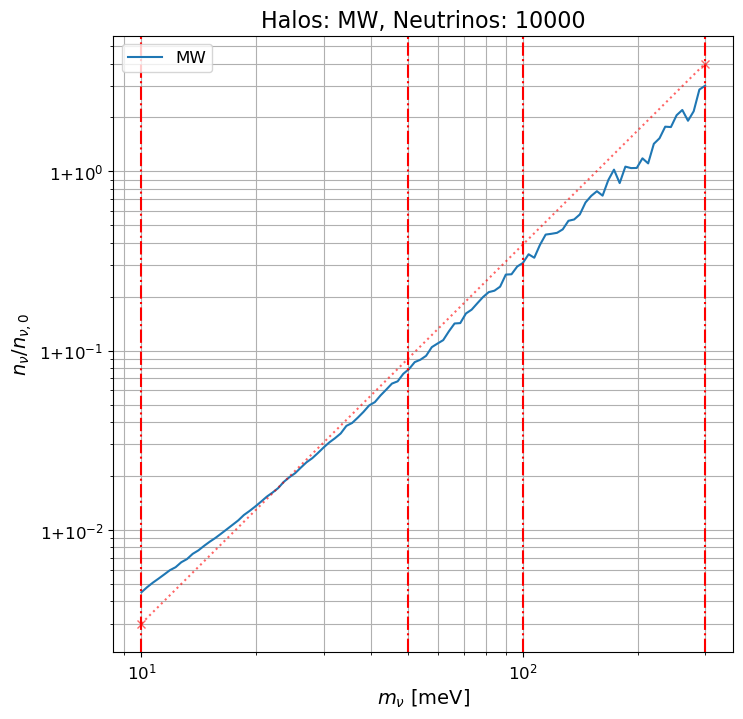

In [1]:
from shared.preface import *
import shared.functions as fct


# 10 to 300 meV like in the paper.
mass_range_eV = np.geomspace(10, 300, 100)*meV

# Load data for MW halo only.
nus = 10000
MW_HALO = True
VC_HALO = False
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO
sim = 'LinfNinf'
fname = f'nus_{nus}_halos_{halos}_{SOLVER}'
u_all_MW = fct.load_sim_data(sim, fname, 'velocities')

output = f'{sim}/number_densities_{fname}.npy'
fct.number_density_1_mass(
    u_all_MW, mass_range_eV, output, 
    average=False, m_average=0.1, z_average=3.5
    )
n_nus_MW = np.load(f'{output}')/N0


'''
# Load data for MW+VC halos.
nus = 10000
MW_HALO = True
VC_HALO = True
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO
u_all_MW_and_VC = fct.load_u_sim(nus, halos)

number_density_1_mass(mass_range_eV, u_all_MW_and_VC, average=True)
n_nus_MW_and_VC = np.load(
    f'neutrino_data/clustering_factors_nus_{nus}_halos_{halos}.npy'
    )/N0
'''


# -------- #
# Plotting #
# -------- #

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(mass_range_eV*1e3, (n_nus_MW-1), label='MW')
# ax.plot(mass_range_eV*1e3, (n_nus_MW_and_VC-1), label='MW+VC')
x_ends = [1e1, 3*1e2]
y_ends = [3*1e-3, 4]
ax.plot(x_ends, y_ends, marker='x', ls=':', c='r', alpha=0.6)

for m in NU_MASSES:
    ax.axvline(m*1e3, c='r', ls='-.')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'Halos: {halos}, Neutrinos: {nus}')
ax.set_xlabel(r'$m_{\nu}$ [meV]')
ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
plt.grid(True, which="both", ls="-")
plt.legend(loc='upper left')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(fct.y_fmt))

plt.savefig(f'figures/clustering_factors_nus_{nus}_halos_{halos}.pdf')
plt.show()

# print('Max value:', np.max(n_nus), np.max(n_nus-1))

## Fermi-Dirac shape comparisons.

In [ ]:
# Load data.
nus = 10000
MW_HALO = True
VC_HALO = False
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO
u_all = fct.load_u_sim(nus, halos)

# Position of earth w.r.t Milky Way NFW halo center.
x1, x2, x3 = 8.5, 0., 0.
x0 = np.array([x1, x2, x3])

fig, axs = plt.subplots(2,2, figsize=(12,12))
fig.suptitle(
    'Momentum phase-space distributions' 
    '\n'
    f'({nus} neutrinos)',
    fontsize=18)

for j, m_eV in enumerate(NU_MASSES):

    k = j

    # Convert to momenta.
    p, y = fct.u_to_p_eV(u_all, m_eV)
    p0, p1, y0, y1 = p[:,0], p[:,-1], y[:,0], y[:,-1]

    # Sort.
    order = p0.argsort()
    p0_sort, p1_sort = p0[order], p1[order]
    y0_sort, y1_sort = y0[order], y1[order]

    # Each velocity has a batch of neutrinos!
    # Take min. of each to represent most clustered ones.
    p1_blocks = p1_sort.reshape((Vs, PHIs*THETAs))
    p1_smooth = np.min(p1_blocks, axis=1)
    y0_blocks = y0_sort.reshape((Vs, PHIs*THETAs))
    y0_smooth = y0_blocks[:,0]

    # Fermi Dirac of the smoothed final momenta.
    FDvals = fct.Fermi_Dirac(p1_smooth)

    i = 0
    if j in (2,3):
        i = 1
        j -= 2
    
    # Escape momentum.
    p_esc_eV, y_esc = fct.escape_momentum(
        x0, 0., rho0_MW, Mvir_MW, Rvir_MW, Rs_MW, m_eV
    )
    axs[i,j].axvline(y_esc, c='k', ls='-.', label='y_esc')

    # Original Fermi-Dirac distr.
    pOG = np.geomspace(LOWER, UPPER, len(FDvals))
    FDvalsOG = fct.Fermi_Dirac(pOG)
    yOG = pOG/T_CNB

    axs[i,j].loglog(y0_smooth, FDvals, label='Simulation', c='red', alpha=0.9)
    axs[i,j].loglog(yOG, FDvalsOG, label='Fermi-Dirac', c='blue', alpha=0.7)
    axs[i,j].set_title(f'{m_eV} eV')
    axs[i,j].set_ylabel('FD(p)')
    axs[i,j].set_xlabel(r'$y = p / T_{\nu,0}$')
    axs[i,j].legend(loc='lower left')
    axs[i,j].set_ylim(1e-5, 1e0)
    axs[i,j].set_xlim(1e-2, 1e2)


plt.savefig(f'figures/fermi_dirac_nus_{nus}_halos_{halos}.pdf')
plt.show()

The plot above gives a good visualization, of what the integral for the number density actually computes. Below is the same plot but with the y-axis now representing the integrand precisely.

The "curtain" like behaviour, where the plot gets messy, is for the exact same reason as above, that each velocity is actually a batch (each having a different initial pointing direction in space), and therefore each x-axis points gets multiple y-axis points. This was "smoothed" over in the plot above for visualization purposes.

In [ ]:
# Load data.
nus = 10000
MW_HALO = True
VC_HALO = False
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO
u_all = fct.load_u_sim(nus, halos)

fig, axs = plt.subplots(2,2, figsize=(12,12))
fig.suptitle(
    'Integral for number density' 
    '\n'
    f'({nus} neutrinos)',
    fontsize=18)


for j, m_eV in enumerate(NU_MASSES):

    k = j

    # Convert to first and last momenta (of each neutrino).
    p0, _ = fct.u_to_p_eV(u_all[:,0], m_eV)
    p1, _ = fct.u_to_p_eV(u_all[:,-1], m_eV)

    # Sort momenta.
    ind = p0.argsort()
    p0_sort, p1_sort = p0[ind], p1[ind]

    # Fermi-Dirac value with momentum at end of sim.
    FDvals = fct.Fermi_Dirac(p1_sort)

    # What number density function integrates.
    y = FDvals * p0_sort**2 
    x = p0_sort

    i = 0
    if j in (2,3):
        i = 1
        j -= 2


    # Using all velocities of sim.
    axs[i,j].set_title(f'{m_eV} eV')
    axs[i,j].semilogx(x/T_CNB, y, alpha=0.9)

    # Using 


    # Original Fermi-Dirac distr.
    y_FD = fct.Fermi_Dirac(MOMENTA) * MOMENTA**2
    x_FD = MOMENTA/T_CNB
    axs[i,j].semilogx(x_FD, y_FD, c='orange', alpha=0.8, ls='-.')

    # Plot settings.
    axs[i,j].set_xlabel(r'y = $p_0/T_{CNB}$')
    axs[i,j].set_ylabel(r'$FD(p_1) \cdot p_0^2$')
    # axs[i,j].set_ylim(1e-5, 1)

plt.show()

## Visualizing the neutrino trajectories.

In [ ]:
# %matplotlib qt

from shared.preface import *
import shared.functions as fct

# Positions of all neutrinos.
nus = 10000
MW_HALO = True
VC_HALO = True
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO
x_all = fct.load_x_sim(nus, halos)/1e3  # in Mpc

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Cut parameter: ~15 to see Virgo Cluster, ~0.01 for Sun-GC system
# cut = 15  # Mpc
# ax.set_xlim(-cut,cut)
# ax.set_ylim(-cut,cut)
# ax.set_zlim(-0.1,cut)

cut = 5
ax.set_xlim(X_VC[0]/1e3-cut,X_VC[0]/1e3+cut)
ax.set_ylim(X_VC[1]/1e3-cut,X_VC[1]/1e3+cut)
ax.set_zlim(X_VC[2]/1e3-cut,X_VC[2]/1e3+cut)

# Select every 100th element, starting with first element of array.
# selection = np.arange(nus)[1::100]
selection = np.arange(nus)

z_wanted = 4
z_index = np.abs(ZEDS-z_wanted).argmin()


nu_beyond_Rvir = 0
for i in selection:

    # Positions of 1 neutrino.
    x_nu1 = x_all[i,:z_index]
    x, y, z = x_nu1[:,0], x_nu1[:,1], x_nu1[:,2]

    # Farthest distance from GC at selected redshift.
    dGC = np.sqrt(x[-1]**2 + y[-1]**2 + z[-1]**2)
    if dGC > Rvir_MW/Mpc:
        nu_beyond_Rvir += 1

    # Trim data to only plot data inside 3D box.
    # x[np.abs(x)>cut] = np.nan
    # y[np.abs(y)>cut] = np.nan
    # z[np.abs(z)>cut] = np.nan

    ax.plot3D(x, y, z, alpha=0.2, c='dodgerblue')

print(f'{nu_beyond_Rvir/nus*100} % of neutrinos are beyond Rvir of MW.')

# Indicate location of Virgo Cluster.
# ax.scatter3D(
#     X_VC[0]/1e3, X_VC[1]/1e3, X_VC[2]/1e3, s=10, c='r', label='Virgo Cluster'
#     )

# Indicate location of Galactic Center.
# ax.scatter3D(
#     0.,0.,0., s=10, c='k', label='Galactic Center'
#     )
 

# Draw sphere around GC with radius=Rvir_MW.
rGC = Rvir_MW/Mpc
uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
xGC = rGC * np.cos(uGC) * np.sin(vGC)
yGC = rGC * np.sin(uGC) * np.sin(vGC)
zGC = rGC * np.cos(vGC)

# Trim data to only plot data inside 3D box.
# xGC[np.abs(xGC)>cut] = np.nan
# yGC[np.abs(yGC)>cut] = np.nan
# zGC[np.abs(zGC)>cut] = np.nan

ax.plot_surface(
    xGC, yGC, zGC, alpha=0.8, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)

# Draw sphere around Virgo CLuster with radius=Rvir_VC.
rVC = Rvir_VC/Mpc
uVC, vVC = np.mgrid[0:2 * np.pi:20j, 0:np.pi:20j]
xVC = rVC * np.cos(uVC) * np.sin(vVC)
yVC = rVC * np.sin(uVC) * np.sin(vVC)
zVC = rVC * np.cos(vVC)

# Trim data to only plot data inside 3D box.
xVC[np.abs(xVC)>cut] = np.nan
yVC[np.abs(yVC)>cut] = np.nan
zVC[np.abs(zVC)>cut] = np.nan

ax.plot_surface(
    xGC+(X_VC[0]/1e3), yGC+(X_VC[1]/1e3), zGC+(X_VC[2]/1e3), alpha=0.8, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)
ax.set_xlabel('x-axis (Mpc)')
ax.set_ylabel('y-axis (Mpc)')
ax.set_zlabel('z-axis (Mpc)')

ax.view_init(elev=8., )

plt.legend()
plt.savefig(f'figures/3D_trajectories_nus_{nus}_halos_{halos}.pdf')
plt.show()

## Statistics from the simulation.

### Percentage of neutrinos inside/outside MW halo.

In [ ]:
from shared.preface import *
import shared.functions as fct

# Positions of all neutrinos.
nus = 10000
MW_HALO = True
VC_HALO = False
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO
x_all = fct.load_x_sim(nus, halos)/1e3  # in Mpc
u_all = fct.load_u_sim(nus, halos)*(kpc/s)/(km/s)  # in km/s

dists = np.sqrt(np.sum(x_all**2, axis=2))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

percent_inHalo = np.zeros(len(ZEDS))
for i, _ in enumerate(ZEDS):

    # Select neutrinos inside Rvir_MW.
    dists_at_z = dists[:,i]
    inHalo = dists_at_z[dists_at_z<(Rvir_MW/Mpc)]
    percent_inHalo[i] = len(inHalo)/nus*100

'''
zline = 0.1
ax.axvline(1+zline, c='r', ls='-.', label=f'z={zline}')

ax.semilogx((1+ZEDS), percent_inHalo)
ax.set_xlabel(f'1+z')
ax.set_ylabel(r'$\%$ of $\nu$ inside MW halo')
ax.set_title(f'{nus} neutrinos: ' + r'amount in-/outside $R_{vir}^{MW}$')

plt.legend()
plt.show()
'''




filenames = []
for i, z in enumerate(ZEDS[::10]):

    # Plot percentage of neutrinos, which have reached certain distance.
    at_z_index = np.abs(ZEDS-z).argmin()
    distances_at_z = dists[:,at_z_index]
    dist_range = np.geomspace(np.min(dists), np.max(dists), 100)
    perc_dist = [
        len(distances_at_z[distances_at_z >= r])/nus*100 for r in dist_range
    ]
    plt.semilogx(dist_range, perc_dist)

    # Create temporary file
    filename = f'figures/{i}.png'
    filenames.append(filename)  

    # Make last frame last longer, by adding multiple times.
    if z == ZEDS[::10][-1]:
        for i in range(15):
            filenames.append(filename)

    # Save the temporary image.
    plt.savefig(filename)
    plt.close()


# Make GIF.
with imageio.get_writer('figures/Perc_of_Nus.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove temporary files.
for filename in set(filenames):
    os.remove(filename)


# magnitudes = np.sqrt(np.sum(u_all**2, axis=2))
# print(u_all.shape, magnitudes.shape)

# u_medians = np.median(magnitudes, axis=0)
# plt.semilogx((1+ZEDS), u_medians)
# plt.show()


### Maximum distance traveled

In [ ]:
from shared.preface import *
import shared.functions as fct

# Positions of all neutrinos.
nus = 10000
MW_HALO = True
VC_HALO = False
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO
x_all = fct.load_x_sim(nus, halos)/1e3  # in Mpc

print(f'{np.max(x_all)*1e3:.2e}')

### Analytical evolution of virial radius of the halos.

In [ ]:
RvirMW_evo = [fct.R_vir_fct(z, Mvir_MW) for z in ZEDS]
RvirVC_evo = [fct.R_vir_fct(z, Mvir_VC) for z in ZEDS]

plt.plot(1+ZEDS, RvirMW_evo/kpc, label='MW')
plt.plot(1+ZEDS, RvirVC_evo/kpc, label='VC')
plt.legend()
plt.show()

### 

## Redshift dependence (Fig. 4 Mertsch et al. (2020)).

In [ ]:
def n_nu_of_redshift(m_eV):
    
    # Convert to momenta. 
    p, _ = fct.u_to_p_eV(u_all, m_eV)

    n_nus = np.zeros(len(ZEDS))
    for i, _ in enumerate(ZEDS):

        # Calculate number density.
        n_nus[i] = fct.number_density(p[:,0], p[:,i])

    np.save(
        f'neutrino_data/z_dependence_nus_{nus}_halos_{halos}_{m_eV}eV.npy', 
        n_nus
        )


# Plotting.
fig, ax = plt.subplots(1,1, figsize=(8,14))

colors = ['blue', 'orange', 'green', 'red']

# ----------------- #
# Load data for MW. #
# ----------------- #
nus = 10000
MW_HALO = True
VC_HALO = False
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO
u_all = fct.load_u_sim(nus, halos)

for j, m in enumerate(NU_MASSES):
    n_nu_of_redshift(m)

    n = np.load(
        f'neutrino_data/z_dependence_nus_{nus}_halos_{halos}_{m}eV.npy'
        )/N0
    # print('Max:', np.max(n),'Mean:', np.mean(n))

    ax.semilogy(ZEDS, n-1, c=colors[j])

# -------------------- #
# Load data for MW+VC. #
# -------------------- #
nus = 10000
MW_HALO = True
VC_HALO = True
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO
u_all = fct.load_u_sim(nus, halos)

for j, m in enumerate(NU_MASSES):
    n_nu_of_redshift(m)

    n = np.load(
        f'neutrino_data/z_dependence_nus_{nus}_halos_{halos}_{m}eV.npy'
        )/N0
    # print('Max:', np.max(n),'Mean:', np.mean(n))

    ax.semilogy(ZEDS, n-1, c=colors[j], ls='-.')



ax.set_title(f'{nus} neutrinos, solver={SOLVER}')
ax.set_xlabel('z')
ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
ax.set_ylim(1e-3, 3e1)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(fct.y_fmt))
plt.savefig(f'figures/z_dependence_nus_{nus}_halos_{halos}.pdf')
plt.show()

## 

## Initial and final momenta.

In [ ]:
# Load data.
nus = 10000
MW_HALO = True
VC_HALO = False
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO
u_all = fct.load_u_sim(nus, halos)

# Position of earth w.r.t Milky Way NFW halo center.
x1, x2, x3 = 8.5, 0., 0.
x0 = np.array([x1, x2, x3])

fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.suptitle(
    'Initial and final momenta (sorted)' 
    '\n'
    f'({nus} neutrinos)',
    fontsize=18)

for j, m_eV in enumerate(NU_MASSES):

    # Convert to momenta.
    p, y = fct.u_to_p_eV(u_all, m_eV)
    p0, p1, y0, y1 = p[:,0], p[:,-1], y[:,0], y[:,-1]

    # Sort.
    order = p0.argsort()
    p0_sort, p1_sort = p0[order], p1[order]
    y0_sort, y1_sort = y0[order], y1[order]

    i = 0
    if j in (2,3):
        i = 1
        j -= 2
    
    # Escape momentum.
    p_esc_eV, y_esc = fct.escape_momentum(
        x0, 0., rho0_MW, Mvir_MW, Rvir_MW, Rs_MW, m_eV
    )
    axs[i,j].axhline(y_esc, c='k', ls='-.', label='y_esc')

    x = np.arange(nus)
    axs[i,j].semilogy(x, y0_sort, label='initial momentum')
    axs[i,j].semilogy(x, y1_sort, label='final momentum', alpha=0.6)
    axs[i,j].set_title(f'{m_eV} eV')
    axs[i,j].set_xlabel('Neutrino number')
    axs[i,j].set_ylabel(r'$p / T_{\nu,0}$')
    axs[i,j].legend(loc='lower right')

plt.show()